In [1]:
#Import libs
import os

from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from elasticsearch.exceptions import NotFoundError

import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from scipy.optimize import curve_fit

In [2]:
#Create index using modified version of IndexFiles.py
%run IndexFiles.py --index novels_full --path novels/*.txt

Indexing 33 files
Reading files ...
Indexing ...


In [3]:
def count_words(index, alpha):
    lpal = []
    voc = {}
    
    try:
        client = Elasticsearch()

        
        sc = scan(client, index=index, doc_type='document', query={"query" : {"match_all": {}}})
        for s in sc:
            tv = client.termvectors(index=index, doc_type='document', id=s['_id'], fields=['text'])
            if 'text' in tv['term_vectors']:
                for t in tv['term_vectors']['text']['terms']:
                    if t in voc:
                        voc[t] += tv['term_vectors']['text']['terms'][t]['term_freq']
                    else:
                        voc[t] = tv['term_vectors']['text']['terms'][t]['term_freq']
        for v in voc:
            lpal.append((v.encode("utf8", "ignore"), voc[v]))

        print('%s Words' % len(lpal))
    except NotFoundError:
        print('Index %s does not exists' % index)
    
    return lpal, voc

In [4]:
# count the words
lpal, _ = count_words("novels_full", False)


61823 Words


                 word  frequency   rank
13562             the     206546      1
9219               of     116786      2
587               and     101586      3
13767              to      84200      4
84                  a      65238      5
6939               in      57955      6
6770                i      37791      7
13559            that      37280      8
14875             was      34576      9
7430               it      31682     10
6399               he      27976     11
6541              his      27824     12
832                as      25167     13
15228            with      24993     14
5535              for      22801     15
7419               is      22058     16
6267              had      20869     17
921                at      19429     18
9265               on      19043     19
1918               by      18644     20
9063              not      17747     21
15459             you      17540     22
1210               be      17493     23
1893              but      17033     24


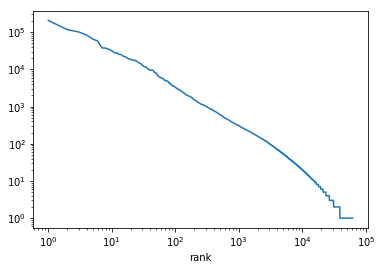

In [5]:
# Create data frame, it's easier to manage

df = pd.DataFrame(lpal, columns=['word','frequency'])
df['word'] = df['word'].str.decode("utf-8")
df = df.sort_values("frequency", ascending = False)
df['rank'] = range(1, len(df) + 1)

# We plot the original version without preprocessing
print(df)
df.plot(x='rank', y='frequency',loglog=True, legend=False)


In [6]:
# remove stupid terms such as numbers, url’s, binary or unreadable stuff, dates, etc

def clear_df(df):
    # Use stop_words list from NLTK
    f = open('stop_words.txt', 'r')
    reader = f.readlines()
    f.close()
    stop_words = [s.strip() for s in reader]
    
    print("Original size: ", len(df))

    # remove stop words, number, email, url
    r = re.compile(r'.*[\d|@|\.|_].*')
    ndf = df.loc[~df['word'].isin(stop_words) & ~df.word.apply(lambda x: bool(r.match(x)))]

    print("After clean, size: ", len(ndf))
    return ndf


Original size:  61823
After clean, size:  56453
                word  frequency   rank
11629           said      10489      1
9267             one       9468      2
8786              mr       8391      3
15339          would       8041      4
3121           could       5673      5
13727           time       5425      6
14429           upon       5044      7
8270             man       4874      8
5858         general       4826      9
9256             old       4629     10
8415             may       4361     11
14117            two       4313     12
8023          little       3985     13
6114           great       3875     14
11892            see       3712     15
8200            made       3645     16
8839            must       3587     17
14974           well       3546     18
7965            like       3453     19
5378           first       3440     20
7672            know       3166     21
8789            much       3144     22
6015            good       3129     23
8970           n

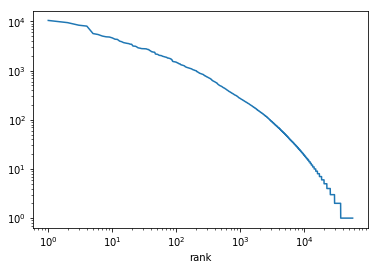

In [7]:
# However, we see there is stop words and some unmeaningful stuff, let's clear
ndf = clear_df(df)

# Now we redo the ranking and plot
ndf = ndf.sort_values("frequency", ascending = False)
ndf['rank'] = range(1, len(ndf) + 1)

# Now we have better word collection, however we can see the plot is very affected by first high ranking words
print(ndf)
ndf.plot(x='rank', y='frequency',loglog=True, legend=False)



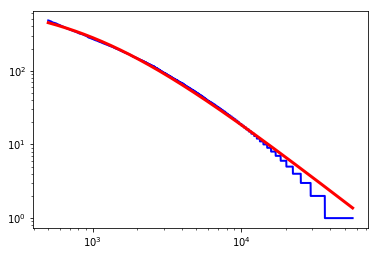

alpha =  1.5678423947288782
beta =  927.5702358034353
constant =  39723061.62341447


In [8]:
# Zips law
# f = c / (rank + b)^a
# ?c ?a ?b

def zip_law(rank, alpha, beta, constant):
    return constant / (rank+beta)**(alpha)
    
# We ignore first 500 high ranking word in order to predict better the long tail
threshold = 500
    
param, _ = curve_fit(zip_law, ndf['rank'][threshold:], ndf['frequency'][threshold:])
 
plt.plot(ndf['rank'][threshold:], ndf['frequency'][threshold:], color='blue', lw=2)
plt.plot(ndf['rank'][threshold:], zip_law(ndf['rank'][threshold:], *param), color='red', lw=3)
plt.yscale('log')
plt.xscale('log')
plt.show()

# The params a,b,c
print("alpha = ", param[0])
print("beta = ", param[1])
print("constant = ", param[2])


In [9]:
# Now in order to simulate Heaps law, we need create index by different number of documents

# D is the number of documents
docs = glob.glob("novels/*.txt")
D = len(docs)

# So we're going to run D iterations, for each iteration we collect N total words number 
# and d different words number

In [10]:
print("start indexing")

for i in range(1, D+1):
    print("iteration ", i)
    path = " ".join(docs[:i])
    index = "novels-" + str(i)
    %run IndexFiles.py --index $index --path $path

print("finished")

start indexing
iteration  1
Indexing 1 files
Reading files ...
Indexing ...
iteration  2
Indexing 2 files
Reading files ...
Indexing ...
iteration  3
Indexing 3 files
Reading files ...
Indexing ...
iteration  4
Indexing 4 files
Reading files ...
Indexing ...
iteration  5
Indexing 5 files
Reading files ...
Indexing ...
iteration  6
Indexing 6 files
Reading files ...
Indexing ...
iteration  7
Indexing 7 files
Reading files ...
Indexing ...
iteration  8
Indexing 8 files
Reading files ...
Indexing ...
iteration  9
Indexing 9 files
Reading files ...
Indexing ...
iteration  10
Indexing 10 files
Reading files ...
Indexing ...
iteration  11
Indexing 11 files
Reading files ...
Indexing ...
iteration  12
Indexing 12 files
Reading files ...
Indexing ...
iteration  13
Indexing 13 files
Reading files ...
Indexing ...
iteration  14
Indexing 14 files
Reading files ...
Indexing ...
iteration  15
Indexing 15 files
Reading files ...
Indexing ...
iteration  16
Indexing 16 files
Reading files ...
Indexing

In [11]:
#For each index count words

print("Start simulation")
Nl = []
dl = []

# For the case of heaps law, the preprocessing step can be skipped.
for i in range(1, D+1):
    print("iteration ", i)    
    lpal, _ = count_words("novels-" + str(i), False)
    df = pd.DataFrame(lpal, columns=['word','frequency'])
    df['word'] = df['word'].str.decode("utf-8")
    df = clear_df(df)
    
    d = len(df.index)
    N = df['frequency'].sum()
    print("Total number N: ", N, "\t\t unique word number: ", d)
    Nl.append(N)
    dl.append(d)


Start simulation
iteration  1
6825 Words
Original size:  6825
After clean, size:  6390
Total number N:  28635 		 unique word number:  6390
iteration  2
11399 Words
Original size:  11399
After clean, size:  10662
Total number N:  108082 		 unique word number:  10662
iteration  3
13428 Words
Original size:  13428
After clean, size:  12626
Total number N:  124339 		 unique word number:  12626
iteration  4
18408 Words
Original size:  18408
After clean, size:  17596
Total number N:  210308 		 unique word number:  17596
iteration  5
24037 Words
Original size:  24037
After clean, size:  23207
Total number N:  373324 		 unique word number:  23207
iteration  6
25049 Words
Original size:  25049
After clean, size:  24216
Total number N:  400921 		 unique word number:  24216
iteration  7
25804 Words
Original size:  25804
After clean, size:  24969
Total number N:  418810 		 unique word number:  24969
iteration  8
27276 Words
Original size:  27276
After clean, size:  25880
Total number N:  445209 		

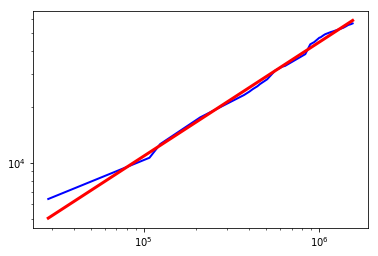

k =  9.230328206591347
beta =  0.6141579887156269


In [12]:
# Heaps law
# d = k * N^B

def heaps_law(N, k, beta):
    return k * N**beta
    
param, _ = curve_fit(heaps_law, Nl, dl)
 
plt.plot(Nl, dl, color='blue', lw=2)
plt.plot(Nl, heaps_law(Nl, *param), color='red', lw=3)
plt.yscale('log')
plt.xscale('log')
plt.show()

# The params k and beta
print("k = ", param[0])
print("beta = ", param[1])